# DFL - Decision-Focused Learning for VRPs
## Using SPO+

In [1]:
from util import *
import torch
import numpy as np
from solver import GurobiSolver
from spo import CostPredictor, SPOplus

# load the autoreload extension
%load_ext autoreload
# set the level of reloading
%autoreload 2

In [2]:
vrps_train = [parse_datafile(f'../data/cvrp_1000_10_5_1/instance_{i}') for i in range(800)]
vrps_test = [parse_datafile(f'../data/cvrp_1000_10_5_1/instance_{i}') for i in range(800, 1000)]

Parsing datafile: ../data/cvrp_1000_10_5_1/instance_0...
Parsing datafile: ../data/cvrp_1000_10_5_1/instance_1...
Parsing datafile: ../data/cvrp_1000_10_5_1/instance_2...
Parsing datafile: ../data/cvrp_1000_10_5_1/instance_3...
Parsing datafile: ../data/cvrp_1000_10_5_1/instance_4...
Parsing datafile: ../data/cvrp_1000_10_5_1/instance_5...
Parsing datafile: ../data/cvrp_1000_10_5_1/instance_6...
Parsing datafile: ../data/cvrp_1000_10_5_1/instance_7...
Parsing datafile: ../data/cvrp_1000_10_5_1/instance_8...
Parsing datafile: ../data/cvrp_1000_10_5_1/instance_9...
Parsing datafile: ../data/cvrp_1000_10_5_1/instance_10...
Parsing datafile: ../data/cvrp_1000_10_5_1/instance_11...
Parsing datafile: ../data/cvrp_1000_10_5_1/instance_12...
Parsing datafile: ../data/cvrp_1000_10_5_1/instance_13...
Parsing datafile: ../data/cvrp_1000_10_5_1/instance_14...
Parsing datafile: ../data/cvrp_1000_10_5_1/instance_15...
Parsing datafile: ../data/cvrp_1000_10_5_1/instance_16...
Parsing datafile: ../dat

In [3]:
# solve the VRPs with the actual edge costs and save the solutions
for vrp in vrps_train + vrps_test:
    solver = GurobiSolver(vrp)
    solver.solve()
    vrp.actual_solution = solver.get_decision_variables()
    vrp.actual_obj = solver.get_actual_objective()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-16


In [4]:
# keep 5% of the train instances for validation
vrps_val = vrps_train[::int(len(vrps_train) / 5)]
vrps_train = [vrp for vrp in vrps_train if vrp not in vrps_val]


def validation_loss(cost_model, vrps, spo_plus):
    with torch.no_grad():
        loss = 0.0
        for vrp in vrps:
            edge_features = torch.tensor([edge.features for edge in vrp.edges], dtype=torch.float32).view(-1)
            predicted_edge_costs = cost_model(edge_features)
            for i, edge in enumerate(vrp.edges):
                edge.predicted_cost = predicted_edge_costs[i]
            solver = GurobiSolver(vrp, mode=SolverMode.SPO)
            solver.solve()
            loss += spo_plus(predicted_edge_costs, vrp.actual_solution, vrp.actual_obj, solver.get_decision_variables(),
                             solver.get_spo_objective())
        return loss / len(vrps)

In [14]:
num_edges = len(vrps_train[0].edges)
num_features = len(vrps_train[0].edges[0].features)
cost_model = CostPredictor(num_edges * num_features, num_edges)
optimizer = torch.optim.Adam(cost_model.parameters(), lr=1e-4)
spo_plus = SPOplus()
num_epochs = 1
for epoch in range(num_epochs):
    mean_loss = 0
    for idx, vrp in enumerate(vrps_train):
        optimizer.zero_grad()
        # get the edge features
        edge_features = torch.tensor([edge.features for edge in vrp.edges], dtype=torch.float32).view(-1)
        # predict the edge costs
        predicted_edge_costs = cost_model(edge_features)
        # set the predicted edge costs
        for i, edge in enumerate(vrp.edges):
            edge.predicted_cost = predicted_edge_costs[i]
        # calculate the loss
        solver = GurobiSolver(vrp, mode=SolverMode.SPO)
        solver.solve()
        loss = spo_plus(predicted_edge_costs, vrp.actual_solution, vrp.actual_obj, solver.get_decision_variables(),
                        solver.get_spo_objective())
        # backpropagation
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
        print(f'Epoch {epoch + 1} / {num_epochs}, instance {idx + 1} / {len(vrps_train)}, loss: {loss.item()}')
    mean_loss /= len(vrps_train)
    print(
        f'Epoch {epoch + 1} / {num_epochs} done, mean loss: {mean_loss}, validation loss: {validation_loss(cost_model, vrps_val, spo_plus)}')
    if (epoch + 1) % 10 == 0:
        test(cost_model, vrps_test, GurobiSolver, is_two_stage=False)

pred_costs: tensor([-1.2566,  0.9684,  2.0647,  1.0192,  0.7386,  0.2497, -0.5004, -0.4034,
         0.6349, -0.3886,  0.3612, -0.0120, -0.7808, -1.0544,  0.6439,  0.5250,
        -0.7770,  1.1074,  0.6978, -0.5242, -1.2038,  0.6061,  0.7670, -0.5592,
        -1.2141, -1.8701,  0.0938, -1.2646,  1.6783, -0.8586,  0.1394, -0.4586,
        -0.3685, -0.0460,  0.8964,  1.3022, -1.6574, -0.3436,  0.2902, -0.9237,
         0.1109, -1.4605,  0.7551, -0.7202,  1.5804,  0.4836, -0.2046, -0.2587,
        -0.7639,  0.5097, -0.0565,  0.1895, -0.2696, -0.3075, -0.4178, -0.6702,
         0.4491,  0.8699, -0.0360, -0.2726, -1.2154, -1.1389,  1.2198,  0.7799,
        -0.5942,  1.4388, -0.6541,  0.9621,  2.0500,  1.0663,  0.3016,  0.0808,
        -0.5286,  0.4126,  0.1656,  1.3558,  1.6947,  0.9746,  0.1866, -0.2464,
         0.5697,  0.3146,  0.3964,  0.5914,  1.8869,  0.9295,  0.0082, -0.4315,
        -0.8225, -1.0303], grad_fn=<AddBackward0>)
true_decision: [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0

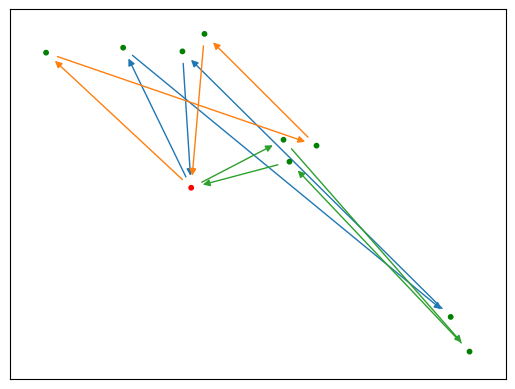

2.519613882754333

In [11]:
# testing
# vrp = vrps_train[761]
vrp = vrps_test[0]

solver = GurobiSolver(vrp)
solver.solve()
draw_solution(solver)
solver.get_actual_objective()

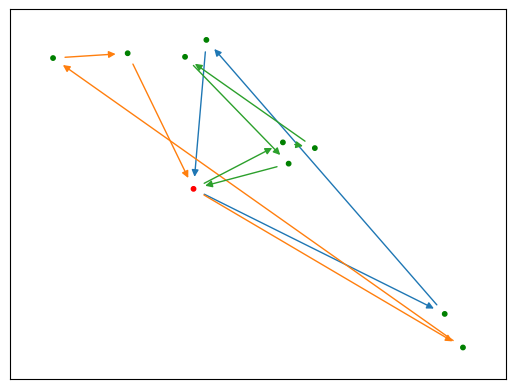

4.674793412927727

In [12]:
predicted_edge_costs = cost_model(torch.tensor([edge.features for edge in vrp.edges], dtype=torch.float32).view(-1))
for i, edge in enumerate(vrp.edges):
    edge.predicted_cost = predicted_edge_costs[i]
solver = GurobiSolver(vrp, mode=SolverMode.PRED_COST)
solver.solve()
draw_solution(solver)
solver.get_actual_objective()

In [8]:
test(cost_model, vrps_test, GurobiSolver, is_two_stage=False)

Parsed instance VRP instance: ../data/cvrp_1000_10_5_1/instance_800, accuracy: 0.25, actual cost: 2.519613882754333, predicted cost: 4.674793412927727
Parsed instance VRP instance: ../data/cvrp_1000_10_5_1/instance_801, accuracy: 0.55, actual cost: 3.8246332902372933, predicted cost: 7.829341777290859
Parsed instance VRP instance: ../data/cvrp_1000_10_5_1/instance_802, accuracy: 0.8227272727272728, actual cost: 5.902370928306482, predicted cost: 10.906201827056378
Parsed instance VRP instance: ../data/cvrp_1000_10_5_1/instance_803, accuracy: 1.0727272727272728, actual cost: 7.890158722013935, predicted cost: 14.5379529572886
Parsed instance VRP instance: ../data/cvrp_1000_10_5_1/instance_804, accuracy: 1.2545454545454546, actual cost: 10.112707085393044, predicted cost: 18.97800430799741
Parsed instance VRP instance: ../data/cvrp_1000_10_5_1/instance_805, accuracy: 1.4853146853146855, actual cost: 12.879361423575611, predicted cost: 24.490890270516502
Parsed instance VRP instance: ../d